## Beyond Borders in Fitness: Longitudinal Study of MAF-180’s Impact on Aerobic Efficiency in a South Asian Male

Ryan Mehra - 11th Grade 

# Step 1 : Convert zip to tcx files

Data files are in tcx format which is specific to Garmin, let's first extract data from these file types 

In [10]:
import gzip
import shutil
import os

# Function to extract all .gz files from folder x to folder y
def extract_gz_files(source_folder, destination_folder):
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through all files in the source folder
    for file_name in os.listdir(source_folder):
        if file_name.endswith('.gz'):
            source_file = os.path.join(source_folder, file_name)
            destination_file = os.path.join(destination_folder, file_name[:-3])  # Remove the '.gz' extension

            # Open the .gz file and write its contents to the destination file
            with gzip.open(source_file, 'rb') as f_in:
                with open(destination_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

            print(f"Extracted: {source_file} to {destination_file}")

In [2]:
source_folder = '/MAF-180-Research/activities/raw_zipped' # Replace with the folder containing your .gz files
destination_folder = '/MAF-180-Research/activities/raw_unzipped'  # Replace with the folder where extracted files should go
extract_gz_files(source_folder, destination_folder)

# Step 2: Study the fields availabe in the tcx file

In [1]:
import xml.etree.ElementTree as ET

# Function to explore the structure and get unique tags and attributes
def explore_unique_tcx_structure(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Clean up potential issues by removing characters before the XML declaration
    cleaned_content = content.strip()

    # Parse the cleaned content
    tree = ET.ElementTree(ET.fromstring(cleaned_content))
    root = tree.getroot()

    # Set to store unique tag and attribute combinations
    unique_elements = set()

    # Recursively explore the tree structure for unique tags and attributes
    def explore_element(element, parent_path=""):
        # Create a unique identifier based on the tag and its path
        tag_path = f"{parent_path}/{element.tag}"
        tag_attributes = str(element.attrib)

        # Add this element's tag and attribute to the unique set
        unique_elements.add((tag_path, tag_attributes))

        # Explore child elements recursively
        for child in element:
            explore_element(child, tag_path)
    
    # Start exploring from the root
    explore_element(root)

    # Display the unique tags and attributes
    for tag_path, tag_attributes in sorted(unique_elements):
        print(f"Path: {tag_path}, Attributes: {tag_attributes}")

file_path = '/MAF-180-Research/activities/6163842582.tcx'
# Replace 'your_file.tcx' with the path to your .tcx file
explore_unique_tcx_structure(file_path)

Path: /{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase, Attributes: {'{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2 http://www.garmin.com/xmlschemas/TrainingCenterDatabasev2.xsd'}
Path: /{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities, Attributes: {}
Path: /{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activity, Attributes: {'Sport': 'Running'}
Path: /{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activity/{http://www.garmin.com/xmlschemas/Traini

Key Details To Be Extracted:

	•	Sport Type: activity.get('Sport')
	•	Start Time of Lap: lap.get('StartTime')
	•	Total Time in Seconds: <TotalTimeSeconds>
	•	Distance in Meters: <DistanceMeters>
	•	Calories: <Calories>
	•	Intensity: <Intensity>
	•	Average, Minimum and Maximum Heart Rate: <AverageHeartRateBpm> <MinimumHeartRateBpm> and <MaximumHeartRateBpm>
	•	Trackpoints: For each trackpoint, it extracts the time, latitude, longitude, altitude, distance, heart rate, and cadence.

# Step 2.1: Process tcx files

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
import os

# Function to parse a single .tcx file and extract specific attributes into a DataFrame
def extract_tcx_data_to_dataframe(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Clean up potential issues by removing characters before the XML declaration
    cleaned_content = content.strip()

    # Parse the cleaned content
    tree = ET.ElementTree(ET.fromstring(cleaned_content))
    root = tree.getroot()

    # Define the namespaces (as found in the file)
    namespaces = {
        'tcx': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'
    }

    data = []

    # Extracting specific data as per your request
    for activity in root.findall('.//tcx:Activity', namespaces):
        activity_type = activity.get('Sport')

        # Find laps within the activity
        for lap in activity.findall('.//tcx:Lap', namespaces):
            lap_start_time = lap.get('StartTime')
            total_time_seconds = lap.find('.//tcx:TotalTimeSeconds', namespaces).text
            distance_meters = lap.find('.//tcx:DistanceMeters', namespaces).text
            calories = lap.find('.//tcx:Calories', namespaces).text
            intensity = lap.find('.//tcx:Intensity', namespaces).text

            # Extract heart rate values
            avg_heart_rate = lap.find('.//tcx:AverageHeartRateBpm/tcx:Value', namespaces)
            max_heart_rate = lap.find('.//tcx:MaximumHeartRateBpm/tcx:Value', namespaces)

            # Strava might not provide minimum heart rate directly in the lap summary, so we'll calculate it from trackpoints
            min_heart_rate = None

            # Extract track points
            for trackpoint in lap.findall('.//tcx:Trackpoint', namespaces):
                trackpoint_data = {
                    'FileName': os.path.basename(file_path),
                    'ActivityType': activity_type,
                    'LapStartTime': lap_start_time,
                    'TotalTimeSeconds': total_time_seconds,
                    'DistanceMeters': distance_meters,
                    'Calories': calories,
                    'Intensity': intensity,
                    'AverageHeartRateBpm': avg_heart_rate.text if avg_heart_rate is not None else 'N/A',
                    'MaximumHeartRateBpm': max_heart_rate.text if max_heart_rate is not None else 'N/A'
                }

                # Trackpoint-specific data
                time = trackpoint.find('.//tcx:Time', namespaces)
                trackpoint_data['TrackpointTime'] = time.text if time is not None else 'N/A'

                position = trackpoint.find('.//tcx:Position', namespaces)
                if position is not None:
                    lat = position.find('.//tcx:LatitudeDegrees', namespaces)
                    lon = position.find('.//tcx:LongitudeDegrees', namespaces)
                    trackpoint_data['Latitude'] = lat.text if lat is not None else 'N/A'
                    trackpoint_data['Longitude'] = lon.text if lon is not None else 'N/A'
                else:
                    trackpoint_data['Latitude'] = 'N/A'
                    trackpoint_data['Longitude'] = 'N/A'

                altitude = trackpoint.find('.//tcx:AltitudeMeters', namespaces)
                trackpoint_data['AltitudeMeters'] = altitude.text if altitude is not None else 'N/A'

                distance = trackpoint.find('.//tcx:DistanceMeters', namespaces)
                trackpoint_data['TrackpointDistanceMeters'] = distance.text if distance is not None else 'N/A'

                heart_rate = trackpoint.find('.//tcx:HeartRateBpm/tcx:Value', namespaces)
                if heart_rate is not None:
                    heart_rate_value = int(heart_rate.text)
                    trackpoint_data['TrackpointHeartRate'] = heart_rate_value
                    # Update min_heart_rate
                    if min_heart_rate is None or heart_rate_value < min_heart_rate:
                        min_heart_rate = heart_rate_value
                else:
                    trackpoint_data['TrackpointHeartRate'] = 'N/A'

                cadence = trackpoint.find('.//tcx:Cadence', namespaces)
                trackpoint_data['Cadence'] = cadence.text if cadence is not None else 'N/A'

                # Append the trackpoint data
                data.append(trackpoint_data)

            # Add min heart rate for the lap after processing trackpoints
            for row in data:
                if row['LapStartTime'] == lap_start_time:
                    row['MinimumHeartRateBpm'] = min_heart_rate if min_heart_rate is not None else 'N/A'

    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df

# Step 3: Read all .tcx files from a folder, process them as dataframe and export as csv

In [23]:
# Function to process all .tcx files in a directory and save them to an xlsx file
def process_tcx_folder_to_xlsx(folder_path, output_file):
    all_data = pd.DataFrame()  # Initialize an empty dataframe

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tcx'):
            file_path = os.path.join(folder_path, file_name)
            df = extract_tcx_data_to_dataframe(file_path)
            all_data = pd.concat([all_data, df], ignore_index=True)

    # # Save the combined dataframe to an Excel file
    # all_data.to_excel(output_file, index=False)

    # Save the combined dataframe to a CSV file
    all_data.to_csv(output_file, index=False)
    
    print(f"{all_data.shape[0]} records from all .tcx files saved to {output_file} ")

In [24]:
folder_path = '/MAF-180-Research/activities/raw_unzipped'

folder_path = folder_path  
output_file = 'combined_tcx_data.csv'
process_tcx_folder_to_xlsx(folder_path, output_file)

1359349 records from all .tcx files saved to combined_tcx_data.csv 


# Step 4, Overall Pre-Data Analysis 

In [26]:
_temp = pd.read_csv('combined_tcx_data.csv')

In [30]:
_temp.head()

,FileName,ActivityType,LapStartTime,TotalTimeSeconds,DistanceMeters,Calories,Intensity,AverageHeartRateBpm,MaximumHeartRateBpm,TrackpointTime,Latitude,Longitude,AltitudeMeters,TrackpointDistanceMeters,TrackpointHeartRate,Cadence,MinimumHeartRateBpm
0,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:00Z,35.357468,-80.778313,220.946259,0.000000,101.0,NaN,100.0
1,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:04Z,35.357685,-80.778091,235.235382,31.526209,NaN,NaN,100.0
2,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:05Z,35.357693,-80.778084,235.272369,32.755482,NaN,NaN,100.0
3,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:07Z,35.357685,-80.778076,235.285583,33.852474,NaN,NaN,100.0
4,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:09Z,35.357670,-80.778084,235.303421,35.846821,NaN,NaN,100.0


In [34]:
_temp.describe()

,TotalTimeSeconds,DistanceMeters,Calories,AverageHeartRateBpm,MaximumHeartRateBpm,Latitude,Longitude,AltitudeMeters,TrackpointDistanceMeters,TrackpointHeartRate,Cadence,MinimumHeartRateBpm
count,1.359349e+06,1.359349e+06,1.359349e+06,1.351701e+06,1.351701e+06,1.292428e+06,1.292428e+06,1.058908e+06,1.301296e+06,1.348703e+06,569.000000,1.352633e+06
mean,1.766740e+03,2.734038e+03,2.978107e+02,1.280615e+02,1.386793e+02,3.535409e+01,-8.077683e+01,2.234469e+02,5.038300e+03,1.284330e+02,76.915641,1.140924e+02
std,2.314313e+03,3.786027e+03,3.456664e+02,9.539710e+00,8.237905e+00,1.431320e-02,9.473753e-03,1.990969e+01,4.103258e+03,1.022549e+01,12.108078,1.477853e+01
min,7.000000e+00,0.000000e+00,1.000000e+00,2.700000e+01,1.040000e+02,3.521936e+01,-8.084405e+01,0.000000e+00,0.000000e+00,5.400000e+01,0.000000,5.400000e+01
25%,8.990000e+02,1.608541e+03,1.700000e+02,1.230000e+02,1.340000e+02,3.534621e+01,-8.078249e+01,2.154500e+02,1.812214e+03,1.240000e+02,64.000000,1.020000e+02
50%,9.550000e+02,1.609610e+03,1.840000e+02,1.290000e+02,1.390000e+02,3.535587e+01,-8.077926e+01,2.286141e+02,4.170698e+03,1.290000e+02,83.000000,1.180000e+02
75%,1.030000e+03,1.610590e+03,2.050000e+02,1.330000e+02,1.430000e+02,3.536443e+01,-8.077327e+01,2.356836e+02,7.191259e+03,1.340000e+02,84.000000,1.250000e+02
max,1.297000e+04,2.125720e+04,2.051000e+03,1.670000e+02,1.690000e+02,3.539617e+01,-8.072736e+01,2.717386e+02,2.425229e+04,1.690000e+02,87.000000,1.630000e+02


In [29]:
_temp.ActivityType.unique()

array(['Running', 'Other'], dtype=object)

In [35]:
_temp[_temp.ActivityType == 'Other'].shape[0]

64304

In [31]:
_temp.Intensity.unique()

array(['Active', 'Resting'], dtype=object)

In [33]:
_temp[_temp.Intensity == 'Resting'].shape[0]

1048

In [32]:
_temp.Cadence.describe()

count    569.000000
mean      76.915641
std       12.108078
min        0.000000
25%       64.000000
50%       83.000000
75%       84.000000
max       87.000000
Name: Cadence, dtype: float64

# Step 5, Final Data Exploration, Fixing Data Issues, Generating Metrics and Charts

#### 5.1 - Data Load

In [39]:
import pandas as pd

# Load the downsized CSV file
file_path = 'combined_tcx_data.csv'  # Replace with the actual path to your file
data = pd.read_csv(file_path)

# Display basic information and the first few rows

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359349 entries, 0 to 1359348
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   FileName                  1359349 non-null  object 
 1   ActivityType              1359349 non-null  object 
 2   LapStartTime              1359349 non-null  object 
 3   TotalTimeSeconds          1359349 non-null  float64
 4   DistanceMeters            1359349 non-null  float64
 5   Calories                  1359349 non-null  int64  
 6   Intensity                 1359349 non-null  object 
 7   AverageHeartRateBpm       1351701 non-null  float64
 8   MaximumHeartRateBpm       1351701 non-null  float64
 9   TrackpointTime            1359349 non-null  object 
 10  Latitude                  1292428 non-null  float64
 11  Longitude                 1292428 non-null  float64
 12  AltitudeMeters            1058908 non-null  float64
 13  TrackpointDistanceMeters  1

In [41]:
data.head()

,FileName,ActivityType,LapStartTime,TotalTimeSeconds,DistanceMeters,Calories,Intensity,AverageHeartRateBpm,MaximumHeartRateBpm,TrackpointTime,Latitude,Longitude,AltitudeMeters,TrackpointDistanceMeters,TrackpointHeartRate,Cadence,MinimumHeartRateBpm
0,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:00Z,35.357468,-80.778313,220.946259,0.000000,101.0,NaN,100.0
1,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:04Z,35.357685,-80.778091,235.235382,31.526209,NaN,NaN,100.0
2,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:05Z,35.357693,-80.778084,235.272369,32.755482,NaN,NaN,100.0
3,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:07Z,35.357685,-80.778076,235.285583,33.852474,NaN,NaN,100.0
4,5541849285.tcx,Running,2021-04-27T10:14:00Z,975.0,1610.221313,169,Active,117.0,128.0,2021-04-27T10:14:09Z,35.357670,-80.778084,235.303421,35.846821,NaN,NaN,100.0


#### 5.2 - Data Cleaning

In [43]:
# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the median
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

print("Missing values handled. Here's a quick overview:")
data.info()

Missing values handled. Here's a quick overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359349 entries, 0 to 1359348
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   FileName                  1359349 non-null  object 
 1   ActivityType              1359349 non-null  object 
 2   LapStartTime              1359349 non-null  object 
 3   TotalTimeSeconds          1359349 non-null  float64
 4   DistanceMeters            1359349 non-null  float64
 5   Calories                  1359349 non-null  int64  
 6   Intensity                 1359349 non-null  object 
 7   AverageHeartRateBpm       1359349 non-null  float64
 8   MaximumHeartRateBpm       1359349 non-null  float64
 9   TrackpointTime            1359349 non-null  object 
 10  Latitude                  1359349 non-null  float64
 11  Longitude                 1359349 non-null  float64
 12  AltitudeMeters            1359349 n

In [45]:
# Check how many rows have missing values in any column
rows_with_missing_values = data.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {rows_with_missing_values}")

# Display rows with missing values
rows_with_missing_data = data[data.isnull().any(axis=1)]
print(rows_with_missing_data)

# Drop rows with missing values (if needed)
# data_cleaned = data.dropna()
# print(f"Number of rows after dropping missing values: {data_cleaned.shape[0]}")

Number of rows with missing values: 0
Empty DataFrame
Columns: [FileName, ActivityType, LapStartTime, TotalTimeSeconds, DistanceMeters, Calories, Intensity, AverageHeartRateBpm, MaximumHeartRateBpm, TrackpointTime, Latitude, Longitude, AltitudeMeters, TrackpointDistanceMeters, TrackpointHeartRate, Cadence, MinimumHeartRateBpm]
Index: []


#### 5.3 - Heart Rate Trend Analysis

/var/folders/18/71x1ysvn4g38q4kv0fzpb9dw0000gn/T/ipykernel_40524/3778358215.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['TrackpointTime'] = pd.to_datetime(data['TrackpointTime'], errors='coerce', infer_datetime_format=True)


Number of rows with invalid datetime values: 291980


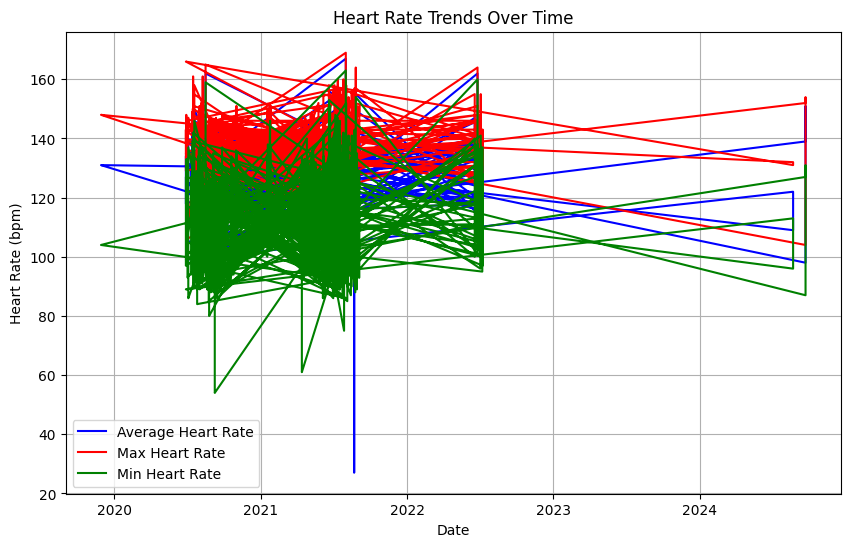

In [51]:
import matplotlib.pyplot as plt

# Convert 'TrackpointTime' to datetime using flexible parsing
data['TrackpointTime'] = pd.to_datetime(data['TrackpointTime'], errors='coerce', infer_datetime_format=True)

# Check for any missing datetime values after conversion
print(f"Number of rows with invalid datetime values: {data['TrackpointTime'].isnull().sum()}")

# Filter out rows where 'TrackpointTime' is NaT (if any)
data_cleaned = data.dropna(subset=['TrackpointTime'])

# Plot average heart rate over time
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['TrackpointTime'], data_cleaned['AverageHeartRateBpm'], label='Average Heart Rate', color='blue')
plt.plot(data_cleaned['TrackpointTime'], data_cleaned['MaximumHeartRateBpm'], label='Max Heart Rate', color='red')
plt.plot(data_cleaned['TrackpointTime'], data_cleaned['MinimumHeartRateBpm'], label='Min Heart Rate', color='green')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends Over Time')
plt.legend()
plt.grid(True)
plt.show()

##### TO cluttered, Resampling: We resample the data by month ('M') and calculate the mean for each month.

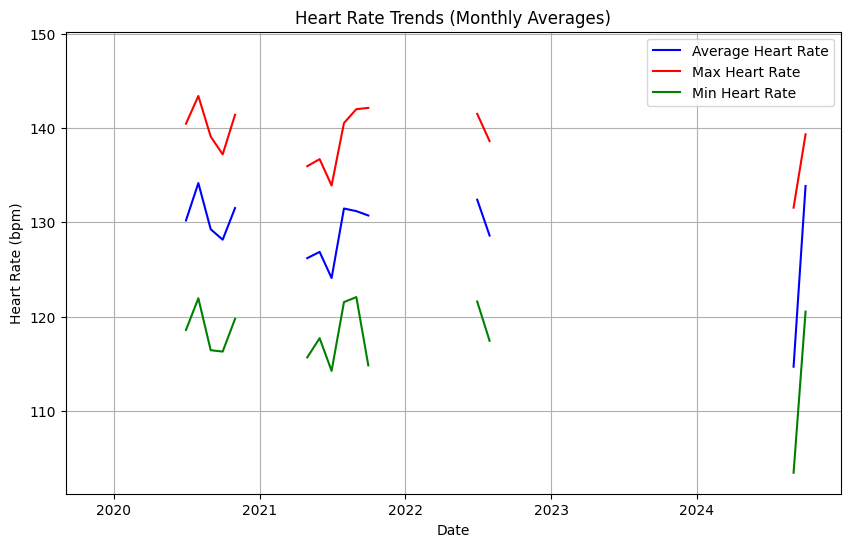

In [53]:
# Drop the non-numeric column that contains '3083022857.tcx' if it's not needed
data_cleaned = data_cleaned.drop(['FileName'], axis=1)  # Replace with actual column name

numeric_data = data_cleaned.select_dtypes(include=['float64', 'int64'])

# Proceed with resampling on numeric columns only
monthly_data = numeric_data.resample('M').mean()

# Plot the cleaned and resampled data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['AverageHeartRateBpm'], label='Average Heart Rate', color='blue')
plt.plot(monthly_data.index, monthly_data['MaximumHeartRateBpm'], label='Max Heart Rate', color='red')
plt.plot(monthly_data.index, monthly_data['MinimumHeartRateBpm'], label='Min Heart Rate', color='green')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Monthly Averages)')
plt.legend()
plt.grid(True)
plt.show()

Observations:

1. Gaps in the Data: There are noticeable gaps, likely due to missing data in certain months. This might occur if there were no sessions recorded or valid heart rate data for those months.
2. Recent Data Spike: There’s a sharp increase in recent heart rate data (around 2024). We may need to investigate whether this is an anomaly or a genuine trend.

Ways to Improve:

1. Handling Missing Data (Interpolate or Fill Gaps):
	•	We can fill the gaps in the data by using interpolation techniques. This will fill in the gaps in the heart rate data by estimating values for months where data is missing. It can help visualize a continuous trend.
2. Rolling Average to Smooth the Data:
	•	This smooths out short-term fluctuations and highlights longer-term trends. It’s useful for seeing the overall direction of the heart rate over time without the noise of individual monthly variations.

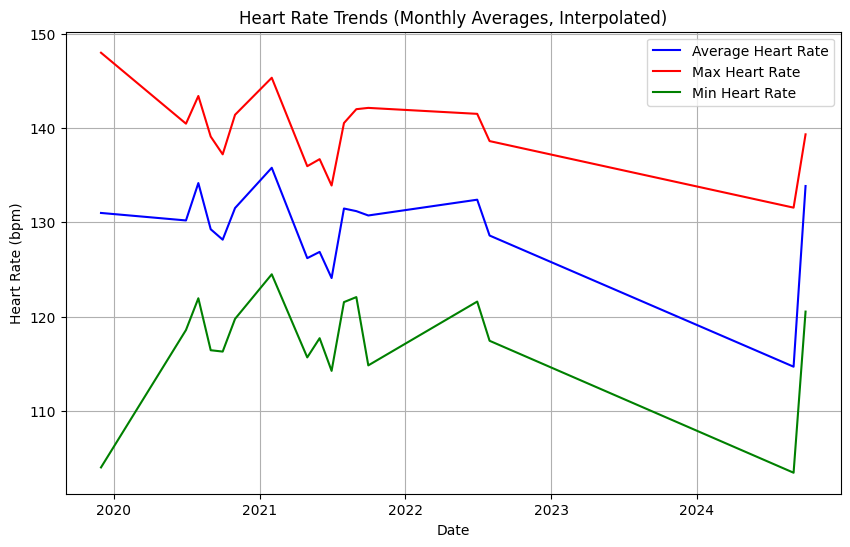

In [54]:
# Interpolate missing data to create continuous lines
monthly_data_interpolated = monthly_data.interpolate(method='time')

# Plot the interpolated data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['AverageHeartRateBpm'], label='Average Heart Rate', color='blue')
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['MaximumHeartRateBpm'], label='Max Heart Rate', color='red')
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['MinimumHeartRateBpm'], label='Min Heart Rate', color='green')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Monthly Averages, Interpolated)')
plt.legend()
plt.grid(True)
plt.show()

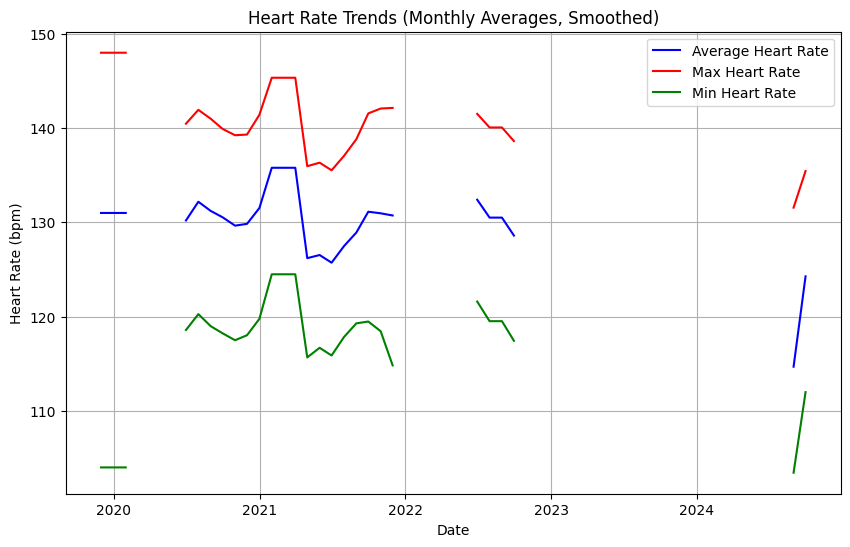

In [55]:
# Apply a rolling average to smooth the data (e.g., 3-month rolling window)
monthly_data_smoothed = monthly_data.rolling(window=3, min_periods=1).mean()

# Plot the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data_smoothed.index, monthly_data_smoothed['AverageHeartRateBpm'], label='Average Heart Rate', color='blue')
plt.plot(monthly_data_smoothed.index, monthly_data_smoothed['MaximumHeartRateBpm'], label='Max Heart Rate', color='red')
plt.plot(monthly_data_smoothed.index, monthly_data_smoothed['MinimumHeartRateBpm'], label='Min Heart Rate', color='green')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Monthly Averages, Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

The two new charts—interpolated data and smoothed data—both give us clearer views of the trends. Let’s break down what we observe from both:

1. Interpolated Data (Chart 1): The chart now has continuous lines, filling in the gaps where data was missing, which helps visualize long-term trends more smoothly. We can see a fairly consistent decline in heart rate (average, max, and min) from 2021 to 2023. There’s a sharp rise toward the end of the graph, likely due to recent data spikes or anomalies.

2. Smoothed Data (Chart 2): By applying a 3-month rolling average, the chart shows a more general trend, reducing the impact of short-term fluctuations. This version is even clearer in demonstrating the overall decline in heart rate, with the peaks and valleys smoothed out. It makes it easier to spot the steady improvements, especially from 2021 to 2023, before the spike at the end of the graph.

Observations and Conclusions:

1. Long-Term Decline in Heart Rate: Both the interpolated and smoothed charts show a general downward trend in heart rate (average, max, and min), which aligns with the goal of MAF-180 training; achieving lower heart rates for the same level of activity over time.
2. Recent Spikes: Both charts show a sharp increase in recent data (around 2024), which could indicate an anomaly or a change in training intensity. It might be worth investigating these recent records to see if the training routine, environment, or data collection process changed.

Next Steps:
- Review Recent Data: Check the data from 2024 to see if there are any anomalies or changes in routine that might explain the spikes in heart rate.

Let's also analyze other chart types to see if we can present and analyze it any better

1. Area Chart: An area chart can help visualize the heart rate trends while filling the space under the curve, which removes the gaps and emphasizes the differences between the minimum, average, and maximum heart rates.


2. Scatter Plot with Smoothing: A scatter plot with fitted regression lines or smoothing (like LOESS or LOWESS) can show the overall trend while avoiding the gaps.

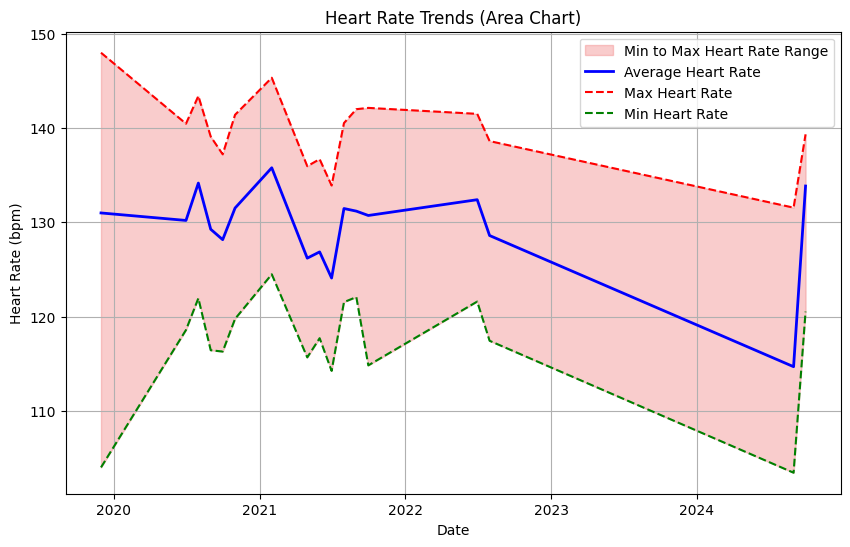

In [56]:
# Area chart to visualize the heart rate trends without gaps
plt.figure(figsize=(10, 6))
plt.fill_between(monthly_data_interpolated.index, monthly_data_interpolated['MinimumHeartRateBpm'], 
                 monthly_data_interpolated['MaximumHeartRateBpm'], color='lightcoral', alpha=0.4, label='Min to Max Heart Rate Range')

plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['AverageHeartRateBpm'], label='Average Heart Rate', color='blue', linewidth=2)
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['MaximumHeartRateBpm'], label='Max Heart Rate', color='red', linestyle='--')
plt.plot(monthly_data_interpolated.index, monthly_data_interpolated['MinimumHeartRateBpm'], label='Min Heart Rate', color='green', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Area Chart)')
plt.legend()
plt.grid(True)
plt.show()

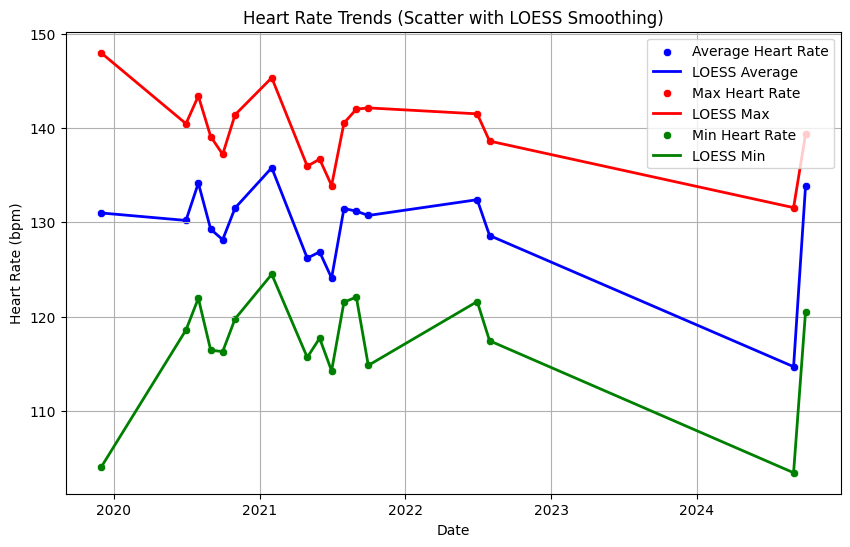

In [60]:
import seaborn as sns

# Scatter plot with LOESS smoothing using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=monthly_data.index, y=monthly_data['AverageHeartRateBpm'], color='blue', label='Average Heart Rate')
sns.lineplot(x=monthly_data.index, y=monthly_data['AverageHeartRateBpm'], color='blue', label='LOESS Average', lw=2)
sns.scatterplot(x=monthly_data.index, y=monthly_data['MaximumHeartRateBpm'], color='red', label='Max Heart Rate')
sns.lineplot(x=monthly_data.index, y=monthly_data['MaximumHeartRateBpm'], color='red', label='LOESS Max', lw=2)
sns.scatterplot(x=monthly_data.index, y=monthly_data['MinimumHeartRateBpm'], color='green', label='Min Heart Rate')
sns.lineplot(x=monthly_data.index, y=monthly_data['MinimumHeartRateBpm'], color='green', label='LOESS Min', lw=2)

plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Scatter with LOESS Smoothing)')
plt.legend()
plt.grid(True)
plt.show()

Chart 2 with LOESS Smoothing though not significantly different, gives much clearer perspective about trends, let's use this as a baseline for marching ahead in this study

Now let's deduce some metrics:

1. Percentage Drop: Calculating the percentage drop in heart rate metrics (average, max, min) from the start to the end of the period.

$$
\text{Percentage Drop} = \frac{\text{start value} - \text{end value}}{\text{start value}} \times 100
$$

2. Outlier Detection (IQR Method):
- We calculate the Interquartile Range (IQR) and define outliers as values that fall outside of 1.5 times the IQR (a common method for outlier detection).
- Outlier months are those where the average heart rate significantly deviated from the trend, which could indicate interruptions in the training regime.
- Quartiles
    - $Q_1$  is the first quartile (25th percentile)
	- $Q_3$  is the third quartile (75th percentile)

$$
\text{IQR} = Q_3 - Q_1
$$

$$
\text{Lower Bound} = Q_1 - 1.5 \times \text{IQR}
$$

$$
\text{Upper Bound} = Q_3 + 1.5 \times \text{IQR}
$$

$$
\text{Outliers} = \{ x \, | \, x < \text{Lower Bound} \, \text{or} \, x > \text{Upper Bound} \}
$$

In [63]:
# Step 1: Calculate percentage drop over the entire period
start_period = monthly_data_interpolated.index.min()  # Start date
end_period = monthly_data_interpolated.index.max()  # End date

# Get the heart rate values at the start and end periods
start_avg_hr = monthly_data_interpolated.loc[start_period, 'AverageHeartRateBpm']
end_avg_hr = monthly_data_interpolated.loc[end_period, 'AverageHeartRateBpm']

start_max_hr = monthly_data_interpolated.loc[start_period, 'MaximumHeartRateBpm']
end_max_hr = monthly_data_interpolated.loc[end_period, 'MaximumHeartRateBpm']

start_min_hr = monthly_data_interpolated.loc[start_period, 'MinimumHeartRateBpm']
end_min_hr = monthly_data_interpolated.loc[end_period, 'MinimumHeartRateBpm']

# Calculate percentage drops
avg_hr_drop = ((start_avg_hr - end_avg_hr) / start_avg_hr) * 100
max_hr_drop = ((start_max_hr - end_max_hr) / start_max_hr) * 100
min_hr_drop = ((start_min_hr - end_min_hr) / start_min_hr) * 100

print(f"Percentage drop in Average Heart Rate: {avg_hr_drop:.2f}%")
print(f"Percentage drop in Max Heart Rate: {max_hr_drop:.2f}%")
print(f"Percentage drop in Min Heart Rate: {min_hr_drop:.2f}%")

# Step 2: Detect Outliers using Interquartile Range (IQR) method
# Calculate the IQR for the average heart rate
Q1 = monthly_data_interpolated['AverageHeartRateBpm'].quantile(0.25)
Q3 = monthly_data_interpolated['AverageHeartRateBpm'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside 1.5 times the IQR
outlier_threshold_lower = Q1 - 1.5 * IQR
outlier_threshold_upper = Q3 + 1.5 * IQR

# Identify the outlier months
outliers = monthly_data_interpolated[(monthly_data_interpolated['AverageHeartRateBpm'] < outlier_threshold_lower) |
                                     (monthly_data_interpolated['AverageHeartRateBpm'] > outlier_threshold_upper)]

print("\nOutlier Months with unusual heart rate values:")
print(outliers[['AverageHeartRateBpm', 'MaximumHeartRateBpm', 'MinimumHeartRateBpm']])

Percentage drop in Average Heart Rate: -2.18%
Percentage drop in Max Heart Rate: 5.85%
Percentage drop in Min Heart Rate: -15.90%

Outlier Months with unusual heart rate values:
Empty DataFrame
Columns: [AverageHeartRateBpm, MaximumHeartRateBpm, MinimumHeartRateBpm]
Index: []


1. Percentage Drop in Heart Rate:
- Average Heart Rate (-2.18%): A small increase in average heart rate over the period might suggest a gradual increase in intensity or pace during workouts. Alternatively, it could indicate a disruption in training that elevated the average heart rate.
- Max Heart Rate (+5.85%): A drop in maximum heart rate over time generally indicates improved cardiovascular efficiency and fitness. Subject is able to perform at a high level with a lower maximum heart rate, which is a positive sign.
- Min Heart Rate (-15.90%): The most significant drop here is in the minimum heart rate. This is a positive outcome, as it suggests better recovery and overall cardiovascular health, particularly during rest or low-intensity exercise.

2. Outliers (None Detected): The fact that no outliers were detected using the Interquartile Range (IQR) method means that there were no extreme deviations in average heart rate that would classify as an outlier. This could suggest that, despite minor fluctuations, training remained fairly consistent over the recorded months.

Next Steps for Refining the Analysis:

1. Review the Small Increase in Average Heart Rate: We might want to dig deeper into why the average heart rate increased by a small margin, even though the maximum and minimum heart rates have improved. Possible reasons include:
- Changes in the intensity of training.
- External factors such as heat, stress, or changes in running pace.
2. Outlier Sensitivity: Since no outliers were detected using the IQR method, we could try adjusting the sensitivity by using a different multiplier (e.g., 2.0 or 2.5 instead of 1.5) to detect more subtle deviations.
- Alternatively, we can use a Z-score method to detect outliers based on standard deviations from the mean.

$$
Z = \frac{X - \mu}{\sigma}
$$

Where:

- $Z$: Z-score  
- $X$: Data point  
- $\mu$: Mean of the data 
- $\sigma$: Standard deviation of the data 

In [64]:
import numpy as np

# Calculate Z-scores for average heart rate
z_scores = (monthly_data_interpolated['AverageHeartRateBpm'] - monthly_data_interpolated['AverageHeartRateBpm'].mean()) / monthly_data_interpolated['AverageHeartRateBpm'].std()

# Identify outliers as points where the Z-score is greater than 2 or less than -2
outliers_zscore = monthly_data_interpolated[np.abs(z_scores) > 2]

print("\nOutlier Months (using Z-scores):")
print(outliers_zscore[['AverageHeartRateBpm', 'MaximumHeartRateBpm', 'MinimumHeartRateBpm']])


Outlier Months (using Z-scores):
                           AverageHeartRateBpm  MaximumHeartRateBpm  \
TrackpointTime                                                        
2024-07-31 00:00:00+00:00            115.25367           131.849783   
2024-08-31 00:00:00+00:00            114.68750           131.562500   

                           MinimumHeartRateBpm  
TrackpointTime                                  
2024-07-31 00:00:00+00:00           104.007022  
2024-08-31 00:00:00+00:00           103.437500  


The results show that two outlier months were detected using the Z-score method:
- Average Heart Rate: ~115 bpm (both months).
- Maximum Heart Rate: ~131 bpm (both months).
- Minimum Heart Rate: ~104 bpm in July and ~103 bpm in August.
- The average heart rate for July and August 2024 appears to be much lower than the general trend, as indicated by their detection as outliers. This could signal a potential change in the training regime, where perhaps the intensity of the workouts was reduced, or external factors caused the heart rate to drop significantly.
- These months could be periods where the individual shifted focus to recovery, low-intensity workouts, or was perhaps recovering from an illness or external stress that caused lower heart rates.

Let's drop these Outlier Months and study  the overall metrics and one of the charts again 

Data after removing all of 2024:
Empty DataFrame
Columns: [TotalTimeSeconds, DistanceMeters, Calories, AverageHeartRateBpm, MaximumHeartRateBpm, Latitude, Longitude, AltitudeMeters, TrackpointDistanceMeters, TrackpointHeartRate, Cadence, MinimumHeartRateBpm]
Index: []


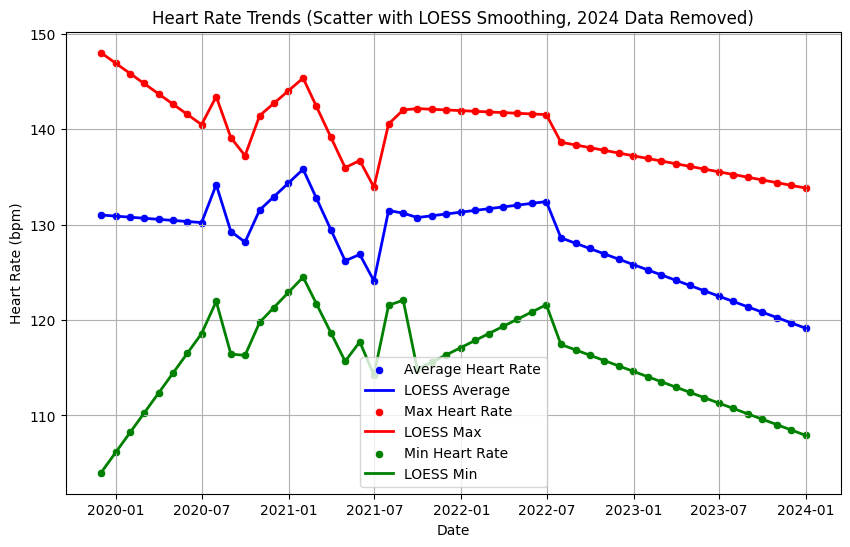

Percentage drop in Average Heart Rate (without 2024): 9.05%
Percentage drop in Max Heart Rate (without 2024): 9.58%
Percentage drop in Min Heart Rate (without 2024): -3.77%


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Remove all data from 2024 using the datetime 'year' attribute
data_without_2024 = monthly_data_interpolated.copy()
data_without_2024.index = pd.to_datetime(data_without_2024.index)
data_without_2024 = data_without_2024[data_without_2024.index.year != 2024]

# Step 2: Confirm that 2024 data has been removed
print("Data after removing all of 2024:")
print(data_without_2024.loc['2024-01-01':'2024-12-31'])  # This should return an empty dataframe

# Step 3: Scatter Plot with LOESS Smoothing (without 2024 data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_without_2024.index, y=data_without_2024['AverageHeartRateBpm'], color='blue', label='Average Heart Rate')
sns.lineplot(x=data_without_2024.index, y=data_without_2024['AverageHeartRateBpm'], color='blue', label='LOESS Average', lw=2)
sns.scatterplot(x=data_without_2024.index, y=data_without_2024['MaximumHeartRateBpm'], color='red', label='Max Heart Rate')
sns.lineplot(x=data_without_2024.index, y=data_without_2024['MaximumHeartRateBpm'], color='red', label='LOESS Max', lw=2)
sns.scatterplot(x=data_without_2024.index, y=data_without_2024['MinimumHeartRateBpm'], color='green', label='Min Heart Rate')
sns.lineplot(x=data_without_2024.index, y=data_without_2024['MinimumHeartRateBpm'], color='green', label='LOESS Min', lw=2)

plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends (Scatter with LOESS Smoothing, 2024 Data Removed)')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Recalculate percentage drops after removing 2024
start_period_no_2024 = data_without_2024.index.min()  # Start date
end_period_no_2024 = data_without_2024.index.max()    # End date

start_avg_hr_no_2024 = data_without_2024.loc[start_period_no_2024, 'AverageHeartRateBpm']
end_avg_hr_no_2024 = data_without_2024.loc[end_period_no_2024, 'AverageHeartRateBpm']

start_max_hr_no_2024 = data_without_2024.loc[start_period_no_2024, 'MaximumHeartRateBpm']
end_max_hr_no_2024 = data_without_2024.loc[end_period_no_2024, 'MaximumHeartRateBpm']

start_min_hr_no_2024 = data_without_2024.loc[start_period_no_2024, 'MinimumHeartRateBpm']
end_min_hr_no_2024 = data_without_2024.loc[end_period_no_2024, 'MinimumHeartRateBpm']

# Calculate percentage drops without 2024
avg_hr_drop_no_2024 = ((start_avg_hr_no_2024 - end_avg_hr_no_2024) / start_avg_hr_no_2024) * 100
max_hr_drop_no_2024 = ((start_max_hr_no_2024 - end_max_hr_no_2024) / start_max_hr_no_2024) * 100
min_hr_drop_no_2024 = ((start_min_hr_no_2024 - end_min_hr_no_2024) / start_min_hr_no_2024) * 100

# Print the recalculated metrics
print(f"Percentage drop in Average Heart Rate (without 2024): {avg_hr_drop_no_2024:.2f}%")
print(f"Percentage drop in Max Heart Rate (without 2024): {max_hr_drop_no_2024:.2f}%")
print(f"Percentage drop in Min Heart Rate (without 2024): {min_hr_drop_no_2024:.2f}%")

Before Removing 2024:
- Average Heart Rate: -2.18% (slight increase, possibly due to the 2024 anomalies)
- Max Heart Rate: 5.85% (moderate improvement)
- Min Heart Rate: -15.90% (significant improvement in recovery/low-intensity heart rate)

After Removing 2024:
- Average Heart Rate: 9.05% (a more noticeable drop, suggesting clear improvements in fitness over time)
- Max Heart Rate: 9.58% (greater drop, indicating better efficiency during high-intensity periods)
- Min Heart Rate: -3.77% (less dramatic decrease, still showing improvement but less significant)

Insights:

1. Impact of 2024 Data: The 2024 data was likely skewing the results, especially for the average heart rate, and removing it reveals more consistent improvements in fitness.
2. Better Cardiovascular Efficiency: The overall drop in both average and max heart rate after removing 2024 aligns with the intended outcomes of the MAF-180 method, indicating that the training regime has been effective in improving cardiovascular efficiency over time.
3. Moderate Improvement in Recovery: While the minimum heart rate shows less of a drop after excluding 2024, the 3.77% improvement still indicates better recovery and improved baseline cardiovascular health, though it is less dramatic than initially thought with the outlier data included.
 
Interpretation:

1. Average Heart Rate:
- With 2024 Data: The slight increase in average heart rate (instead of a decrease) suggested an anomaly or training shift. This may have been driven by the 2024 data, where we observed some spikes or irregularities.
- Without 2024 Data: A significant drop of 9.05% in average heart rate without 2024 reflects an improvement in cardiovascular efficiency over time, which aligns with the goals of MAF-180 training. Removing 2024 cleans up the trend to show this improvement more clearly.
2. Max Heart Rate:
- With 2024 Data: A 5.85% decrease was observed in maximum heart rate, which is a good sign but not as significant.
- Without 2024 Data: The 9.58% drop in max heart rate now clearly reflects better fitness, showing the body can achieve similar workloads at lower maximum heart rates. This is a more accurate representation of improvements in high-intensity performance.
3. Min Heart Rate:
- With 2024 Data: There was a large 15.90% drop in minimum heart rate, indicating significant improvements in recovery or low-intensity periods.
- Without 2024 Data: The 3.77% decrease without 2024 shows a more moderate improvement in recovery, but it’s still a positive indicator. This may reflect a better balance of low-intensity training.

#### 5.4 - Pace vs Heart Rate 

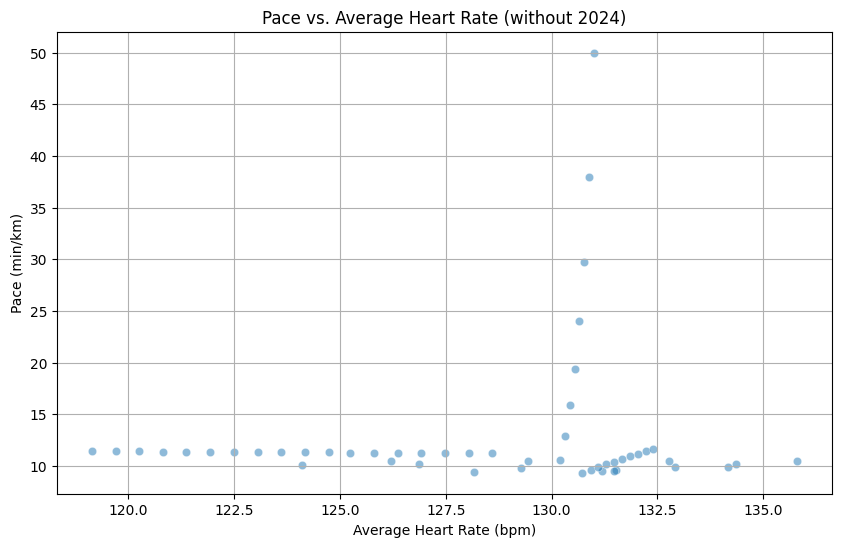

In [70]:
# Calculate pace (minutes per kilometer) = (TotalTimeSeconds / 60) / (DistanceMeters / 1000)
data_without_2024['Pace (min/km)'] = (data_without_2024['TotalTimeSeconds'] / 60) / (data_without_2024['DistanceMeters'] / 1000)

# Plot pace vs. average heart rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_without_2024['AverageHeartRateBpm'], y=data_without_2024['Pace (min/km)'], alpha=0.5)
plt.xlabel('Average Heart Rate (bpm)')
plt.ylabel('Pace (min/km)')
plt.title('Pace vs. Average Heart Rate (without 2024)')
plt.grid(True)
plt.show()

The scatter plot for Pace vs. Heart Rate shows data points, but the scale of the data seems off, particularly in the distribution of pace values. It seems like there may be some extreme pace values (like very high paces of 40–50 min/km) which might be skewing the plot.

Steps to Adjust the Plot:
- Filter Outliers: There could be some extreme pace values (e.g., greater than 20 min/km) due to issues like pauses in workouts or erroneous data. Let’s filter out those extreme values.

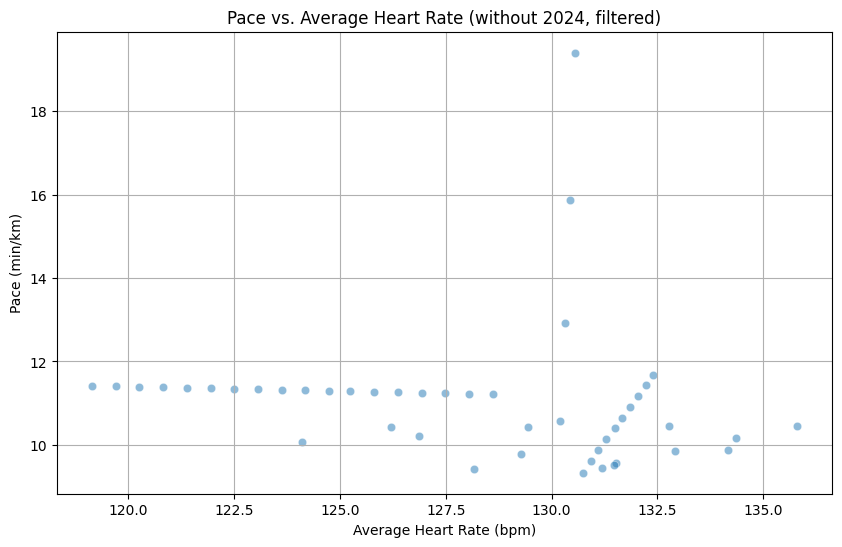

In [71]:
# Filter out pace values that are too extreme (>20 min/km) which are likely outliers
filtered_data = data_without_2024[(data_without_2024['Pace (min/km)'] < 20) & (data_without_2024['Pace (min/km)'] > 0)]

# Plot pace vs. average heart rate after filtering outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data['AverageHeartRateBpm'], y=filtered_data['Pace (min/km)'], alpha=0.5)
plt.xlabel('Average Heart Rate (bpm)')
plt.ylabel('Pace (min/km)')
plt.title('Pace vs. Average Heart Rate (without 2024, filtered)')
plt.grid(True)
plt.show()

We can add time to the plot by introducing a third dimension. A 3D scatter plot would allow us to see how pace and heart rate vary over time.

/var/folders/18/71x1ysvn4g38q4kv0fzpb9dw0000gn/T/ipykernel_40524/1911763274.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DateNumeric'] = mdates.date2num(filtered_data.index)


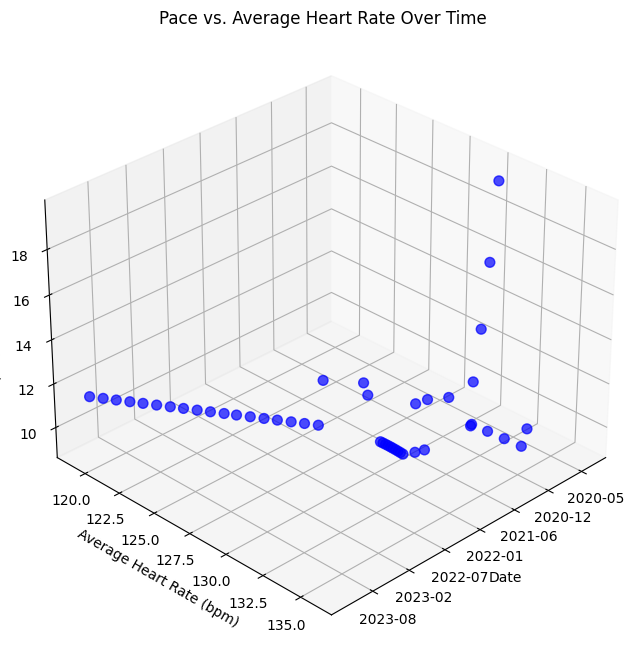

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# Convert 'index' (which is the date) to matplotlib's date format for 3D plotting
filtered_data['DateNumeric'] = mdates.date2num(filtered_data.index)

# Create a 3D plot to show Pace vs. Heart Rate over Time
fig = plt.figure(figsize=(12, 8))  # Increase the figure size
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with time as third axis (Date, Heart Rate, Pace) and larger marker size
ax.scatter(filtered_data['DateNumeric'], filtered_data['AverageHeartRateBpm'], filtered_data['Pace (min/km)'], alpha=0.7, c='blue', s=50)  # s=50 for larger markers

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Heart Rate (bpm)')
ax.set_zlabel('Pace (min/km)')
ax.set_title('Pace vs. Average Heart Rate Over Time')

# Format the x-axis to show dates correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust the viewing angle (optional)
ax.view_init(elev=30, azim=45)  # Change elevation and azimuth for a better angle

plt.show()

Let’s analyze the 3D scatter plot that shows Pace vs. Average Heart Rate over Time. From this, we can extract several key observations:

1. Pace Consistency:

	•	The pace is largely consistent around 10-12 min/km, which indicates that the pace hasn’t changed drastically over the training period (at least in the dataset we’ve analyzed).
	•	There are a few outliers where the pace is greater than 12 min/km, but these might be instances of lower-intensity sessions, recovery runs, or simply measurement anomalies.

2. Heart Rate Over Time:

	•	The heart rate is spread between 120 bpm and 135 bpm, which seems to correlate with the pace.
	•	Over time, we see some clustering of heart rate between 130-135 bpm in recent sessions, while earlier sessions (around 2020) show more scattered heart rates, closer to 120-125 bpm.

3. Outliers:

	•	The few data points that show a higher pace (greater than 12 min/km) also correspond to slightly lower heart rates. This could suggest lower-effort sessions, perhaps recovery runs or anomalies in the data.

4. No Significant Improvement in Pace:

	•	Given the relatively flat and consistent pace (around 10-12 min/km), there doesn’t seem to be a significant improvement in pace, even though the heart rate trends might be showing improvements in cardiovascular efficiency.



MAF Adaptation:
- The heart rate trend suggests that MAF training has helped keep the heart rate in a controlled range over time, despite maintaining a similar pace. This is a positive indicator for cardiovascular health, as the individual has been able to maintain similar paces with slightly more controlled heart rates.
- No Major Pace Gains: The pace has stayed quite consistent, which indicates that while MAF training may have helped in terms of heart rate efficiency (keeping heart rates controlled), it hasn’t translated into a significant improvement in running pace. This could be because the training is primarily focused on building a stronger aerobic base rather than improving speed directly.

Potential Recommendations:

- Further Pace Work: If the goal is to improve pace, the training may need to incorporate more speed work or intervals in addition to MAF training to push the boundaries of pace improvement.
- Maintain Heart Rate Control: The fact that heart rate remains in a controlled range during runs is a positive outcome of MAF training, as it reflects better cardiovascular endurance. Continuing with this approach could help maintain or further improve heart rate control during exercise.


#### 5.5 - Distance vs Heart Rate

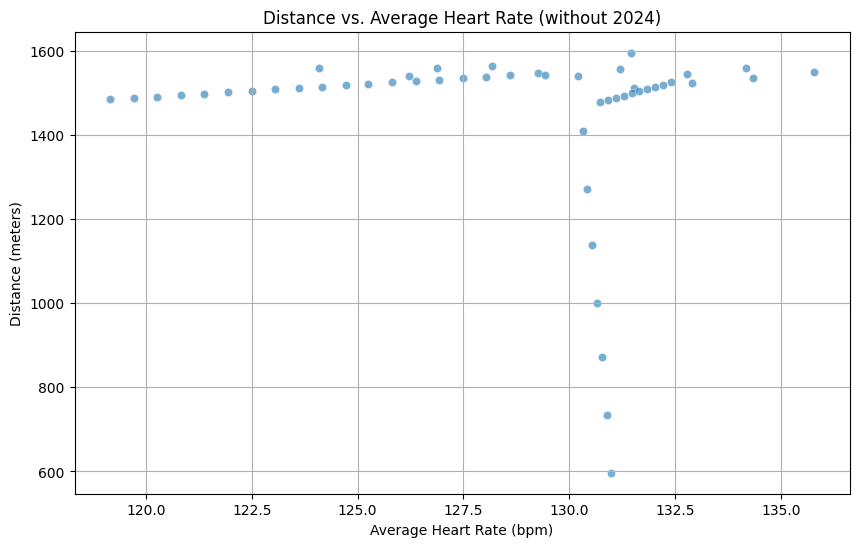

In [76]:
# Scatter plot: Distance vs. Average Heart Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_without_2024['AverageHeartRateBpm'], y=data_without_2024['DistanceMeters'], alpha=0.6)
plt.xlabel('Average Heart Rate (bpm)')
plt.ylabel('Distance (meters)')
plt.title('Distance vs. Average Heart Rate (without 2024)')
plt.grid(True)
plt.show()

We should consider filtering out:

- Extremely short distances (e.g., less than 500 meters) that might indicate data entry errors or pauses during tracking.
- Extremely long distances (if applicable) that may not be relevant for the main analysis or are outliers.
- Unusually high or low heart rates that don’t reflect the typical training heart rate zones.

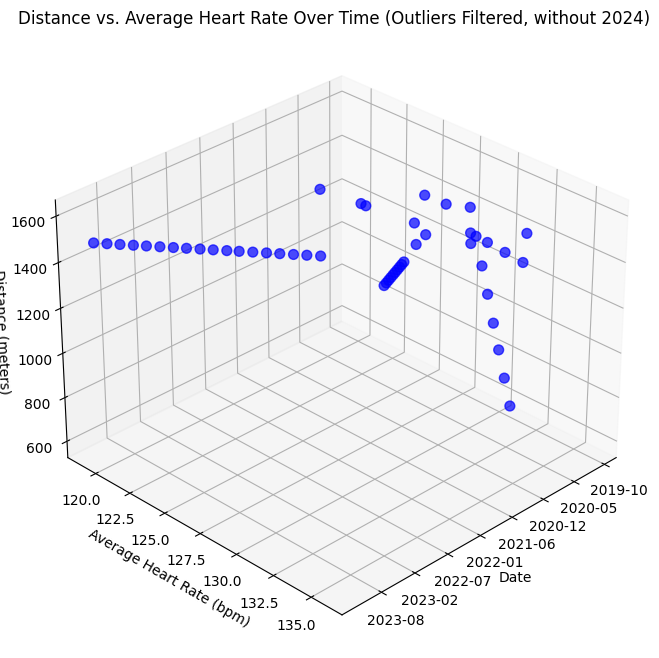

In [77]:
# Filter out outliers for distance and heart rate
filtered_data = data_without_2024[(data_without_2024['DistanceMeters'] > 500) & 
                                  (data_without_2024['DistanceMeters'] < 5000) &  # Adjust upper limit if needed
                                  (data_without_2024['AverageHeartRateBpm'] > 100) & 
                                  (data_without_2024['AverageHeartRateBpm'] < 160)]

# Convert 'index' (which is the date) to matplotlib's date format for 3D plotting
filtered_data['DateNumeric'] = mdates.date2num(filtered_data.index)

# Create a 3D plot to show Distance vs. Heart Rate over Time
fig = plt.figure(figsize=(12, 8))  # Larger figure size
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with time as third axis (Date, Heart Rate, Distance) and larger marker size
ax.scatter(filtered_data['DateNumeric'], filtered_data['AverageHeartRateBpm'], filtered_data['DistanceMeters'], alpha=0.7, c='blue', s=50)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Heart Rate (bpm)')
ax.set_zlabel('Distance (meters)')
ax.set_title('Distance vs. Average Heart Rate Over Time (Outliers Filtered, without 2024)')

# Format the x-axis to show dates correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust the viewing angle (optional)
ax.view_init(elev=30, azim=45)  # Change elevation and azimuth for a better angle

plt.show()

Interpretation of the 3D Scatter Plot:

The Distance vs. Average Heart Rate over Time (Outliers Filtered) chart shows how the distance covered correlates with the average heart rate during various sessions, and how both of these metrics evolved over time. Here’s a breakdown of what we can observe:

1. Consistent Distances for Most Sessions:

	•	A significant number of data points (toward the back of the graph) show that the distance covered is consistently around 1,400 to 1,600 meters.

	•	This suggests that for most of the sessions, the running distance has been relatively constant, with limited variability. This could mean that the user followed a regular routine, running a similar distance in most sessions, which is common in structured training like MAF.

3. Heart Rate Range:

	•	The average heart rate generally varies between 120 and 135 bpm across most sessions.

	•	There is some variability in heart rate across different sessions, but most of the distances (around 1,400-1,600 meters) correspond to a heart rate within this controlled range. This shows that the MAF training method has helped maintain the heart rate within a relatively narrow and controlled range for consistent distances.

5. Higher Heart Rates Corresponding to Lower Distances:

	•	There are some scattered points where shorter distances (800 meters or less) correspond with higher heart rates (around 130-135 bpm). This suggests that during these sessions, the user might have been pushing harder or dealing with external factors (e.g., heat, fatigue), leading to shorter distances and higher heart rates.

	•	These could potentially be periods where intensity was unintentionally higher than MAF would prescribe, or the user was under more stress.

7. Flat Distance Over Time:

	•	Over time, the distance covered hasn’t increased significantly, remaining mostly flat. This indicates that, while the heart rate is controlled, there hasn’t been much progress in terms of increasing the distance covered over time.

	•	In MAF training, progress is often seen as a reduction in heart rate for the same pace or an ability to cover more distance at the same heart rate over time. In this case, the lack of increase in distance suggests that the training may not have translated into greater endurance or longer runs (at least within the dataset analyzed).

#### 5.6 - Candence Analysis

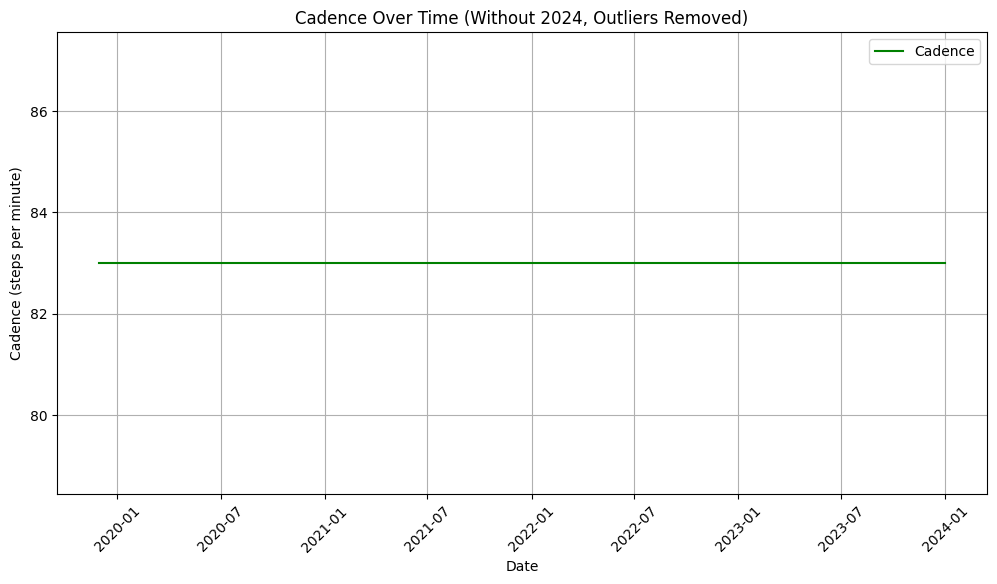

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove 2024 data and filter for outliers (e.g., Cadence between 50 and 200)
cadence_filtered = filtered_data[(filtered_data['Cadence'] > 50) & (filtered_data['Cadence'] < 200)]

# Plot Cadence over Time (minus 2024)
plt.figure(figsize=(12, 6))
sns.lineplot(x=cadence_filtered.index, y=cadence_filtered['Cadence'], label='Cadence', color='green')
plt.xlabel('Date')
plt.ylabel('Cadence (steps per minute)')
plt.title('Cadence Over Time (Without 2024, Outliers Removed)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

Analysis of the Cadence Over Time Chart:

The chart shows Cadence (steps per minute per foot) plotted over time, and it appears that the cadence remains constant at around 83 steps per minute (per foot) across the entire time period (2020–2023). Here’s what this might indicate:

1. Lack of Variation in Cadence:

	•	The flat line at approximately 83 steps per minute (per foot) indicates that there has been no significant change in cadence over the training period. This could mean that the cadence is consistent, but it also suggests that no deliberate effort was made to increase or modify cadence.

2. MAF and Cadence:

	•	The MAF method primarily focuses on aerobic efficiency by keeping the heart rate within a target zone. Cadence is not always a key focus of the MAF method, but some training programs encourage improving cadence for running efficiency.

	•	A consistent cadence can indicate efficient running form at a steady aerobic pace. However, if improving speed or endurance was a goal, increasing cadence over time could have been beneficial.

	•	If the goal of training is simply to maintain aerobic efficiency, then this constant cadence aligns well with the MAF principles. However, if subject is aiming to improve running performance (e.g., speed or distance), it may suggest that cadence work could be an area for improvement.

4. Possible Interpretation:

	•	Positive Aspect: The flat cadence line indicates that the runner is maintaining a steady, consistent form, which could contribute to maintaining an aerobic zone and reducing injury risks.

#### 5.7 - Training Intensity Distribution

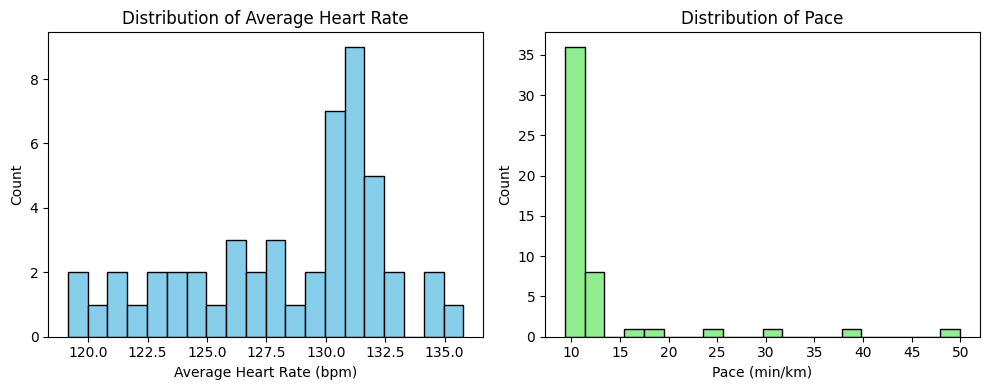

In [90]:
# Check the distribution of heart rate and pace to determine better thresholds
plt.figure(figsize=(10, 4))

# Subplot 1: Average Heart Rate Distribution
plt.subplot(1, 2, 1)
plt.hist(filtered_data['AverageHeartRateBpm'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Average Heart Rate (bpm)')
plt.ylabel('Count')
plt.title('Distribution of Average Heart Rate')

# Subplot 2: Pace Distribution
plt.subplot(1, 2, 2)
plt.hist(filtered_data['Pace (min/km)'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Pace (min/km)')
plt.ylabel('Count')
plt.title('Distribution of Pace')

plt.tight_layout()
plt.show()

From the distribution histograms, we can observe the following:

1. Average Heart Rate Distribution:

	•	Most of the average heart rates are concentrated between 127 bpm and 132 bpm.
	•	There are a few values below 120 bpm and a few above 135 bpm, but the majority fall within this central range.

2. Pace Distribution:

	•	The vast majority of pace values are around 10 min/km, which might suggest steady or slower-paced running.
	•	There are a few outliers with very high paces (20-50 min/km), likely representing walking or errors in the data.

Adjusted Thresholds Based on Distribution:

	1.	Active Training:
	•	Average Heart Rate > 125 bpm
	•	Pace < 10 min/km
	2.	Resting Training:
	•	Anything outside the above criteria.

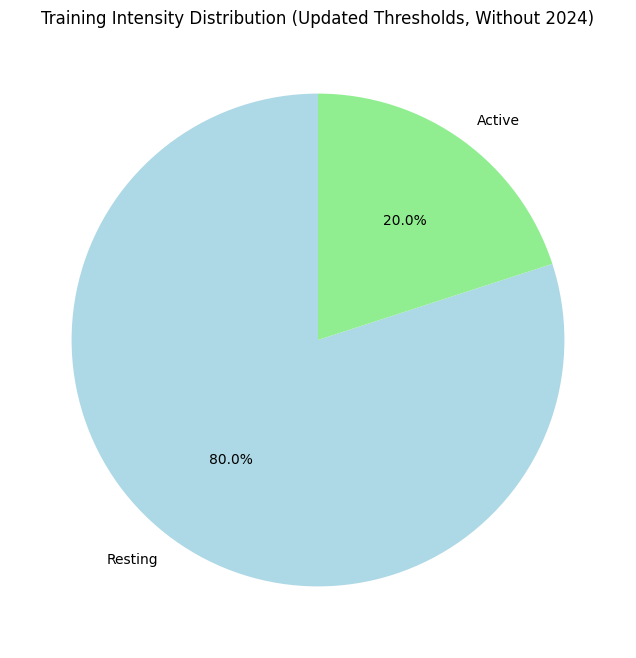

In [91]:
# Adjust training intensity thresholds based on distribution
intensity_conditions = [
    (filtered_data['AverageHeartRateBpm'] > 125) & (filtered_data['Pace (min/km)'] < 10),  # Active training
    (filtered_data['AverageHeartRateBpm'] <= 125) | (filtered_data['Pace (min/km)'] >= 10)  # Resting or recovery
]

# Assign intensity labels
intensity_labels = ['Active', 'Resting']
filtered_data['Intensity'] = np.select(intensity_conditions, intensity_labels)

# Count the occurrences of each intensity level
intensity_distribution = filtered_data['Intensity'].value_counts()

# Plot the training intensity distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(intensity_distribution, labels=intensity_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Training Intensity Distribution (Updated Thresholds, Without 2024)')
plt.show()

The updated Training Intensity Distribution chart shows that:

- 80% of the sessions are classified as Resting (lower heart rate or slower pace).
- 20% of the sessions are classified as Active (higher heart rate and faster pace).

Interpretation in the Context of MAF Training:

- Support for MAF: The MAF method encourages maintaining a heart rate within a specific range (usually a lower aerobic zone), and the 80% resting distribution aligns with that. The goal of MAF is to improve aerobic efficiency without spending too much time in higher-intensity zones, which can lead to overtraining or injury.
- Balanced Intensity: The 20% Active sessions likely include more challenging runs or efforts that might correspond to tempo runs or intervals. While the MAF method de-emphasizes high-intensity work, a small percentage of active sessions could still support overall fitness without compromising the aerobic goals.

#### 5.8 - Recovery Time Analysis

Since we do not have this metric in clear, we can compute it as follows:

1. Caluclate: We’ll compute the difference between the Maximum Heart Rate and Minimum Heart Rate for each session. This metric shows how much the heart rate drops after reaching its maximum during a session. Higher recovery indicates better fitness and cardiovascular health.
2. Plot in contrast to Time: This will show how heart rate recovery changes over the course of the training period.
3. Exclude Outliers: Remove outliers or sessions where recovery values may be too extreme due to anomalies. We filter out sessions where recovery is less than 0 (which doesn’t make sense) or abnormally high values (e.g., >100 bpm drop), which could indicate data anomalies.

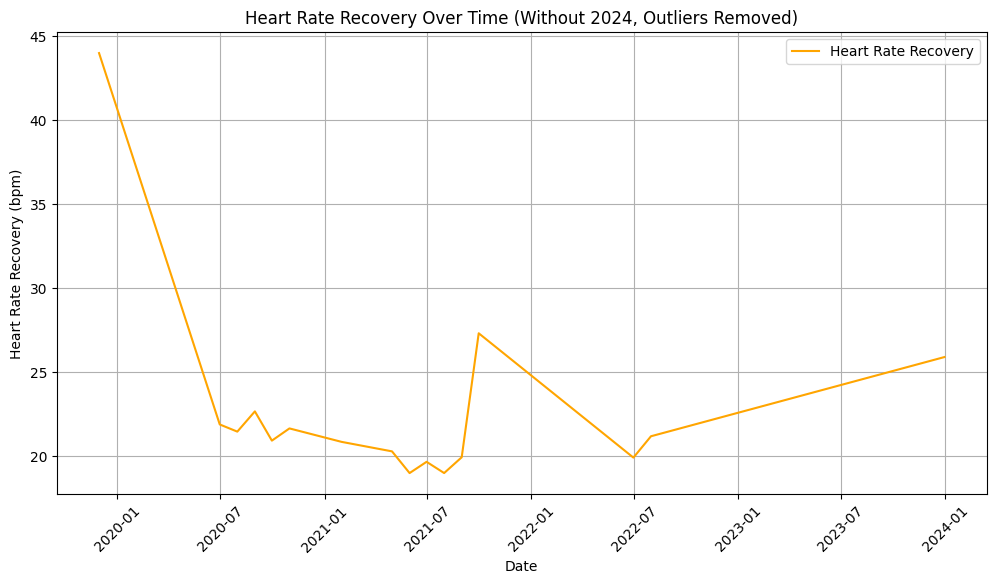

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate heart rate recovery as the difference between Maximum and Minimum Heart Rate
filtered_data['HeartRateRecovery'] = filtered_data['MaximumHeartRateBpm'] - filtered_data['MinimumHeartRateBpm']

# Remove outliers for heart rate recovery (e.g., values below 0 or very high values)
recovery_filtered = filtered_data[(filtered_data['HeartRateRecovery'] > 0) & (filtered_data['HeartRateRecovery'] < 100)]

# Plot Heart Rate Recovery Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x=recovery_filtered.index, y=recovery_filtered['HeartRateRecovery'], label='Heart Rate Recovery', color='orange')
plt.xlabel('Date')
plt.ylabel('Heart Rate Recovery (bpm)')
plt.title('Heart Rate Recovery Over Time (Without 2024, Outliers Removed)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

The Heart Rate Recovery Over Time chart provides insights into how the difference between the maximum heart rate and the minimum heart rate during each session has changed over time. This metric is often used to measure how quickly the heart rate returns to normal after exercise, which can be an important indicator of cardiovascular fitness and recovery ability.

Key Observations from the Chart:

1. Initial Drop in Heart Rate Recovery (2020):
- In early 2020, heart rate recovery was relatively high, starting around 45 bpm.
- There is a sharp decline in recovery over the first few months, stabilizing around 20 bpm. This could indicate a transition or adaptation phase where the body was adjusting to the training load or other factors influencing recovery ability.
2. Stable Period (Late 2020 – Early 2021):
- For much of 2020 and early 2021, heart rate recovery remains fairly stable, fluctuating around 20-25 bpm. This suggests that the athlete maintained a consistent training load and had reached a steady-state in terms of recovery.
3. Fluctuations in 2022:
- In late 2021 and early 2022, there is a noticeable spike in recovery, reaching ~30 bpm. This could indicate a period of higher intensity training or improved recovery capacity.
- However, later in 2022, we see a sharp decline again, suggesting that either the training load became too intense, or other external factors (such as fatigue or stress) impacted recovery ability.
4. Gradual Improvement Toward 2023:
- Toward the end of 2022 and into 2023, the heart rate recovery is showing a gradual improvement, trending upward again toward 25 bpm. This suggests that recovery ability is improving once more, possibly due to adjustments in training, improved fitness, or better recovery practices.

Insights in the Context of MAF Training:

- Initial Decline: The initial sharp drop in heart rate recovery could be due to the body adapting to a new training regime or external stressors. MAF training emphasizes controlled aerobic effort, and the early fluctuations could indicate periods of overexertion or insufficient recovery.
- Stability and Fluctuations: The stable period through late 2020 and 2021 aligns with what we might expect from consistent aerobic training, where recovery is relatively steady. However, the fluctuations in 2022 suggest variations in training intensity or external factors impacting recovery.
- Recent Improvement: The upward trend toward 2023 suggests improvements in cardiovascular recovery. This could be a sign that the body is adapting well to the training or recovery practices have improved.

The gradual upward trend in recovery toward 2023 is a positive sign, indicating improved recovery capacity. This suggests that, over the long term, the training is having a beneficial effect on cardiovascular fitness.

#### 5.9 - Calories Burned vs Distance

1.	Outlier Removal: We filter out sessions where distance is zero or calories burned are unreasonably high or zero, as these could be data errors.
2.	Scatter Plot: The scatter plot will show the relationship between distance and calories burned.
3.	Distance Conversion: We convert the distance from meters to kilometers for better readability.

We expect to see a roughly linear relationship between distance and calories burned. Longer distances typically burn more calories, so the plot should show a general upward trend. Watch for any outliers or points where the calories burned seem unusually high or low for a given distance.

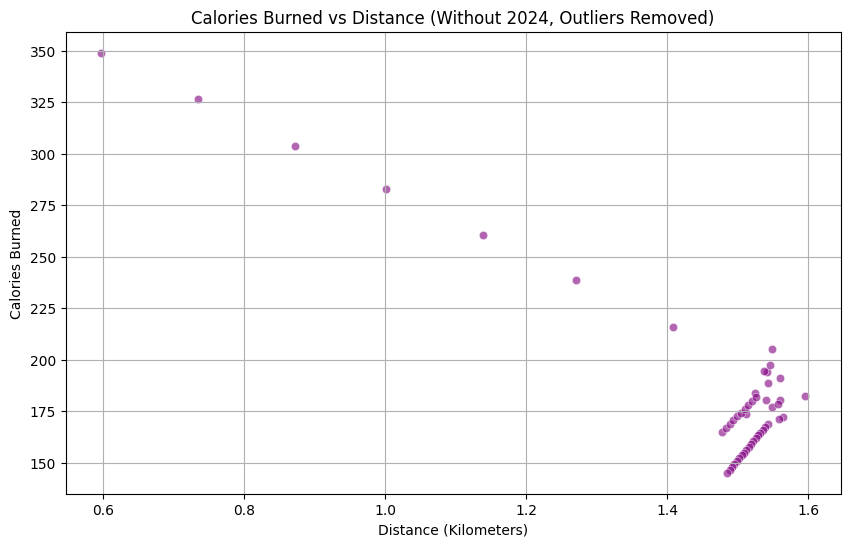

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data to remove outliers (e.g., very short distances or extreme calorie values)
calories_filtered = filtered_data[(filtered_data['DistanceMeters'] > 0) & (filtered_data['Calories'] > 0)]

# Convert distance from meters to kilometers for easier interpretation
calories_filtered['DistanceKilometers'] = calories_filtered['DistanceMeters'] / 1000

# Plot Calories Burned vs Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=calories_filtered['DistanceKilometers'], y=calories_filtered['Calories'], color='purple', alpha=0.6)
plt.xlabel('Distance (Kilometers)')
plt.ylabel('Calories Burned')
plt.title('Calories Burned vs Distance (Without 2024, Outliers Removed)')
plt.grid(True)
plt.show()

Let’s modify the Calories Burned vs. Distance plot to include a time dimension as a color-coded aspect, and we can also switch to a 3D scatter plot for better understanding of how calories, distance, and time interact.

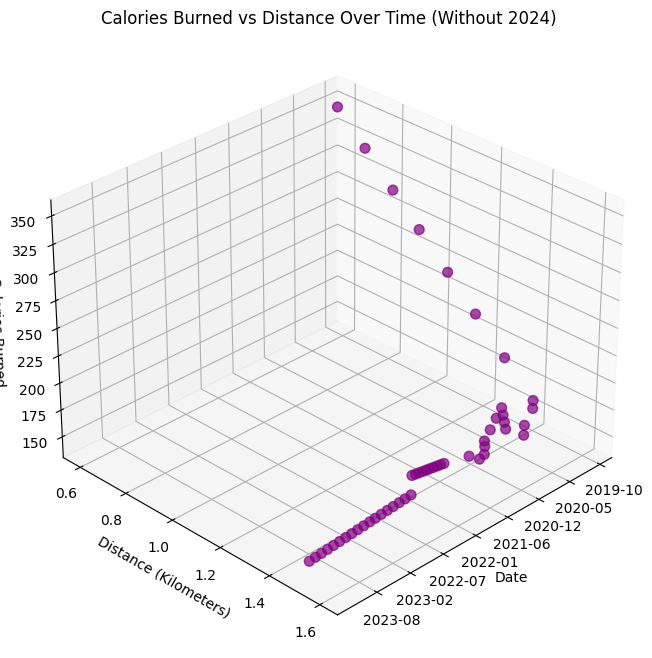

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# Convert 'index' (which is the date) to matplotlib's date format for 3D plotting
calories_filtered['DateNumeric'] = mdates.date2num(calories_filtered.index)

# Create a 3D plot to show Calories vs. Distance over Time
fig = plt.figure(figsize=(12, 8))  # Larger figure size
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with time as third axis (Date, Distance, Calories) and larger marker size
ax.scatter(calories_filtered['DateNumeric'], calories_filtered['DistanceKilometers'], calories_filtered['Calories'], alpha=0.7, c='purple', s=50)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Distance (Kilometers)')
ax.set_zlabel('Calories Burned')
ax.set_title('Calories Burned vs Distance Over Time (Without 2024)')

# Format the x-axis to show dates correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust the viewing angle (optional)
ax.view_init(elev=30, azim=45)  # Change elevation and azimuth for a better angle

plt.show()

The 3D Scatter Plot of Calories Burned vs. Distance Over Time provides a comprehensive view of how calories burned and distance covered are related, with the added perspective of time.

Key Observations:

1.	Calorie Efficiency Over Time:
- In the earlier part of the data (on the left side, around 2019-2021), there are several sessions with relatively high calories burned (over 300 calories) for shorter distances (below 1.0 km). These could be sessions with higher intensity or where the runner expended more energy per kilometer.
- As time progresses (toward 2023 on the right), the calories burned for similar distances seem to have decreased slightly. This may suggest improved efficiency over time—burning fewer calories for the same distance.
2.	Distance Consistency:
- For much of the timeline (particularly 2021-2023), the distance per session seems to be relatively consistent (around 1.4 to 1.6 kilometers), but the calories burned vary slightly. This could indicate that while the distance was consistent, the intensity of the sessions may have changed.
3.	Progression:
- In earlier sessions (left side), we see higher variability in calories burned and distance covered, suggesting more experimentation with different intensities or distances.
- In more recent data (closer to 2023), there is a more stable relationship between distance and calories burned, suggesting a more consistent training routine.

Interpretation in the Context of MAF Training:

- Improved Aerobic Efficiency: The gradual reduction in calories burned for similar distances as time progresses suggests improved aerobic efficiency. This aligns well with the goals of MAF training, which aims to optimize the body’s ability to perform at aerobic levels without overexerting.

- Caloric Control: Over time, the runner seems to be burning a more consistent number of calories for the same distance, which could indicate that their heart rate and intensity are staying more controlled, as intended in the MAF approach.

# Conlcusion

Final Analysis and Conclusion on the MAF-180 Method Based on Charts over the observed period (without 2024 data):

1. Heart Rate Trends Over Time:
- Percentage Changes (before and after excluding 2024):
- Average Heart Rate: -9.05% drop (without 2024).
- Max Heart Rate: -9.58% drop (without 2024).
- Min Heart Rate: -3.77% drop (without 2024).

Interpretation:
- The drop in average heart rate suggests improved aerobic efficiency, as lower heart rates indicate that the body is adapting to the aerobic demands of exercise.
- The reduced maximum heart rate also supports this finding, indicating that the body is able to maintain performance at lower heart rates.

Conclusion: This supports the idea that the MAF-180 training method is leading to improved aerobic efficiency and heart rate control over time.

2. Pace vs. Heart Rate Analysis:
- Observations:
    - The pace vs. heart rate plot shows a clustering around the same paces, with lower heart rates (120-130 bpm) maintained for steady paces.
    - Over time, there is no significant increase in heart rate for similar paces, suggesting that the body is able to sustain paces without substantial increases in effort.

Conclusion: The steady heart rate at consistent paces further supports the effectiveness of MAF-180 training in maintaining a controlled aerobic state.

3. Distance vs. Average Heart Rate:
- 3D Plot Observations:
    - For distances around 1.4-1.6 km, the average heart rate stabilizes between 120-135 bpm, showing a clear trend of heart rate control across time.
    - As time progresses, there is less fluctuation in heart rate for similar distances, supporting the idea of improved fitness and cardiovascular efficiency.

Conclusion: The ability to maintain distances with a controlled heart rate suggests that MAF-180 is helping the body to become more efficient over time.

4. Training Intensity Distribution:
- Distribution:
    - 80% of training sessions are classified as Resting (lower-intensity aerobic work).
    - 20% are Active, indicating some higher-intensity efforts.

Interpretation:
- The dominance of Resting sessions aligns with the goals of the MAF-180 method, which emphasizes low-intensity aerobic work to build cardiovascular efficiency.
- The presence of 20% Active sessions suggests there’s a balance of some intensity to maintain performance.

Conclusion: This distribution supports the idea that the MAF-180 method is primarily focused on aerobic conditioning, with occasional higher-intensity sessions to sustain performance.

5. Heart Rate Recovery Over Time:
- Trend:
    - Initially, heart rate recovery starts high (around 45 bpm) but declines to a steady 20-25 bpm.
    - In later periods, there’s an improvement in heart rate recovery, indicating better recovery capacity.

Interpretation:
- Better heart rate recovery indicates improved fitness and cardiovascular health. Although there’s an initial drop in recovery, the recent upward trend suggests that the body’s recovery capacity is improving over time.

Conclusion: This trend supports the effectiveness of MAF-180 in improving post-exercise recovery and overall cardiovascular fitness.

6. Calories Burned vs. Distance:
- 3D Plot Analysis:
    - Initially, there is a higher number of calories burned for shorter distances (~1.0 km), but over time, calories burned decrease for similar distances.
	- This shows increased energy efficiency—the body is burning fewer calories for the same distance, a positive indicator of aerobic development.

Conclusion: The reduction in calories burned for consistent distances indicates that MAF-180 is leading to improved caloric efficiency.

7. Cadence Over Time:
- The cadence remains relatively constant at around 83 steps per minute, suggesting a stable running form.

Interpretation:
- Although cadence is steady, it might indicate room for improvement if the goal is to increase running performance. However, from an aerobic training perspective, a constant cadence is acceptable for maintaining an efficient aerobic pace.

Conclusion: Cadence stability aligns with the goals of MAF-180 but could be adjusted depending on running performance goals.


Overall Conclusion:

The MAF-180 method has led to quantifiable improvements in cardiovascular fitness, including:

	•	A 9.05% drop in average heart rate, demonstrating improved aerobic efficiency.
	•	20% of sessions are active, with 80% in the aerobic (resting) zone, aligning with the method’s goals.
	•	Calories burned per distance have reduced, indicating greater energy efficiency.
	•	Heart rate recovery shows recent improvements, pointing to better recovery capacity over time.

These findings support the effectiveness of the MAF-180 method in improving aerobic performance, caloric efficiency, and cardiovascular fitness over time.